In [17]:
# mlflow ui --backend-store-uri sqlite:///mlflow.db
# mlflow db upgrade "sqlite:///mlflow.db"

In [18]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import mlflow
import IPython

import warnings
warnings.filterwarnings('ignore')

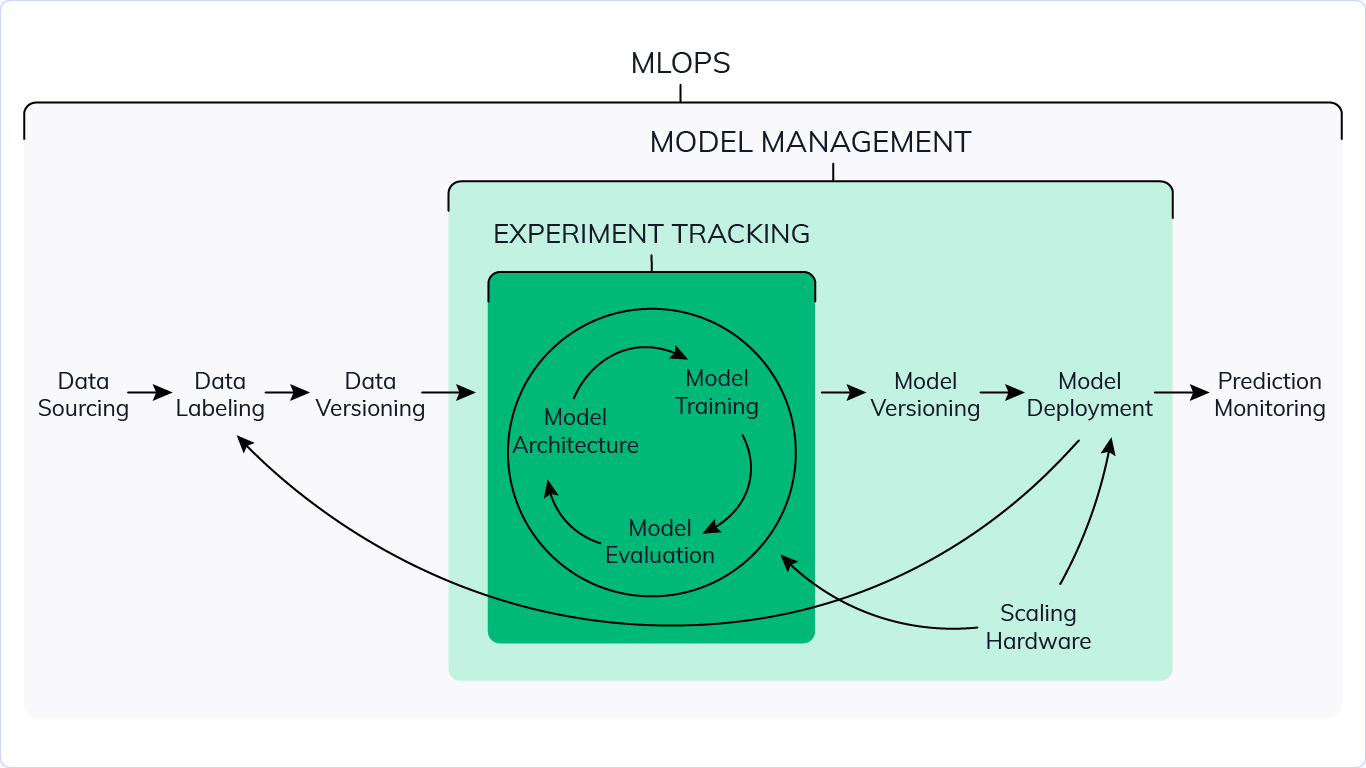

In [19]:
url = 'https://i0.wp.com/neptune.ai/wp-content/uploads/MLOps_cycle.jpg'
IPython.display.Image(url, width = 750)

In [20]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("mlflow-tracking")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='mlflow-tracking', tags={}>

In [21]:
TRAIN_PATH = '../data/green_tripdata_2021-01.parquet'
VALID_PATH = '../data/green_tripdata_2021-02.parquet'

##### Exploratory analysis

In [22]:
df = pd.read_parquet(TRAIN_PATH)

In [23]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [24]:
df.shape

(76518, 20)

In [25]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [26]:
df[['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration']].head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,0 days 00:00:04


In [27]:
td = df.duration.iloc[0]
td.total_seconds() / 60

3.933333333333333

In [28]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [29]:
df[['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration']].head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,0.066667


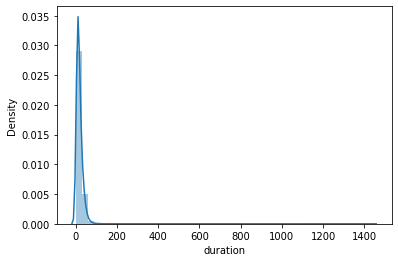

In [30]:
sns.distplot(df.duration)
plt.show()

In [31]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [32]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts[:5]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0}]

In [33]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [34]:
X_train

<76518x508 sparse matrix of type '<class 'numpy.float64'>'
	with 229554 stored elements in Compressed Sparse Row format>

In [35]:
target = 'duration'
y_train = df[target].values

In [36]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [37]:
df_train = read_dataframe(TRAIN_PATH)
df_val = read_dataframe(VALID_PATH)

In [38]:
print(df_train.shape)
print(df_val.shape)

(73908, 21)
(61921, 21)


In [39]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [40]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [41]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
print(train_dicts[:5])

print('*'*20)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
print(val_dicts[:5])

[{'PU_DO': '43_151', 'trip_distance': 1.01}, {'PU_DO': '166_239', 'trip_distance': 2.53}, {'PU_DO': '41_42', 'trip_distance': 1.12}, {'PU_DO': '168_75', 'trip_distance': 1.99}, {'PU_DO': '75_75', 'trip_distance': 0.45}]
********************
[{'PU_DO': '130_205', 'trip_distance': 3.66}, {'PU_DO': '152_244', 'trip_distance': 1.1}, {'PU_DO': '152_48', 'trip_distance': 4.93}, {'PU_DO': '152_241', 'trip_distance': 6.7}, {'PU_DO': '75_42', 'trip_distance': 1.89}]


In [42]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [43]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

##### Basic model and save the output to MLFlow

In [44]:
with mlflow.start_run():
    
    mlflow.set_tag("Data scientist", "Athiq")
    mlflow.log_param("train-path", "data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-path", "data/green_tripdata_2021-02.parquet")

    alpha = 0.01

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse", rmse)

##### Hyperparameter optimization

In [45]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [46]:
X_train

<73908x13221 sparse matrix of type '<class 'numpy.float64'>'
	with 147816 stored elements in Compressed Sparse Row format>

In [47]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [48]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared =False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [49]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [50]:
# Run to get the best params

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

In [52]:
best_params = {
"learning_rate":	0.16529117497407447,
"max_depth":	    44,
"min_child_weight":	9.701492513080472,
"objective":	    'reg:linear',
"reg_alpha":	    0.14787776635324554,
"reg_lambda":	    0.3231916856395473,
"seed":	            42
}

mlflow.xgboost.autolog(disable=True)
mlflow.log_params(best_params)

booster = xgb.train(
    params = best_params,
    dtrain = train,
    num_boost_round = 50,
    evals = [(valid, "validation")],
    early_stopping_rounds = 10
)

y_pred = booster.predict(valid)
rmse = mean_squared_error(y_val, y_pred, squared=False)

mlflow.log_metric("rmse", rmse)
with open('../data/models/preprocessor.b', 'wb') as f_out:
    pickle.dump(dv, f_out)

mlflow.log_artifact("../data/models/preprocessor.b", artifact_path='preprocessor')
mlflow.xgboost.log_model(booster, artifact_path = 'models_mlflow')

[12:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.26742
[1]	validation-rmse:15.87623
[2]	validation-rmse:13.93521
[3]	validation-rmse:12.36842
[4]	validation-rmse:11.11575
[5]	validation-rmse:10.12440
[6]	validation-rmse:9.34578
[7]	validation-rmse:8.73998
[8]	validation-rmse:8.27207
[9]	validation-rmse:7.91205
[10]	validation-rmse:7.63243
[11]	validation-rmse:7.41905
[12]	validation-rmse:7.25543
[13]	validation-rmse:7.12745
[14]	validation-rmse:7.02810
[15]	validation-rmse:6.95106
[16]	validation-rmse:6.88970
[17]	validation-rmse:6.84069
[18]	validation-rmse:6.80200
[19]	validation-rmse:6.77082
[20]	validation-rmse:6.74589
[21]	validation-rmse:6.72446
[22]	validation-rmse:6.70654
[23]	validation-rmse:6.69155
[24]	validation-rmse:6.67786
[25]	validation-rmse:6.66863
[26]	validation-rmse:6.65873
[27]	validation-rmse:6.65174
[28]	validation

ModelInfo(artifact_path='models_mlflow', flavors={'python_function': {'loader_module': 'mlflow.xgboost', 'python_version': '3.8.3', 'data': 'model.xgb', 'env': 'conda.yaml'}, 'xgboost': {'xgb_version': '1.6.1', 'data': 'model.xgb', 'model_class': 'xgboost.core.Booster', 'code': None}}, model_uri='runs:/51674fdfb6b74b0d847359e6011a4e11/models_mlflow', model_uuid='4b299c69106b4beb8eb2c3fc5f11a015', run_id='51674fdfb6b74b0d847359e6011a4e11', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-07-22 07:13:37.971578', mlflow_version='1.27.0')